In [118]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [119]:
from google.colab import drive
drive.mount('/content/drive')
# !unzip '/content/drive/My Drive/Colab Notebooks/CS 412 - Machine Learning/Project/data.zip' -d '/content/drive/My Drive/Colab Notebooks/CS 412 - Machine Learning/Project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
scores_df = pd.read_csv('scores.csv')
print(scores_df.head())

   Unnamed: 0                                  code  grade
0           0  6a2003ad-a05a-41c9-9d48-e98491a90499   90.0
1           1  04f91058-d0f8-4324-83b2-19c671f433dc   97.0
2           2  81fdeb2a-e7e5-4a05-8058-d31ea579b0d9   94.0
3           3  6a903495-c5be-4263-b4dd-75e2bbc30434   97.0
4           4  6d5742c1-77c4-429c-8f6e-ef1262ca5557   93.0


In [121]:
data_path = "data/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:24<00:00,  5.21it/s]


In [122]:
# let's see one of the conversations
#code2convos: keeps all the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [123]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [124]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [125]:
##Reduce noises from texts###

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

# prompts_cleaned = [preprocess_text(prompt) for prompt in prompts]
# questions_cleaned = [preprocess_text(question) for question in questions]

# print(prompts_cleaned)
# print(questions_cleaned)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [126]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [127]:
###Perform TF-IDF vectorization on pre-processed texts###
# vectorizer = TfidfVectorizer(
#      max_df=0.85,
#      min_df=0.01,
#      ngram_range=(1,2),
#      stop_words='english'
#  )

#vectorizer.fit(prompts_cleaned + questions_cleaned)

#prompts_tfidf = vectorizer.transform(prompts_cleaned)
#questions_tfidf = vectorizer.transform(questions_cleaned)

In [128]:
# #REAL ONE
# vectorizer = TfidfVectorizer()
# vectorizer = vectorizer.fit(prompts + questions)

In [129]:
# questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
# questions_TF_IDF.head()

In [130]:
# code2prompts_tf_idf = dict()
# for code, user_prompts in code2prompts.items():
#   if len(user_prompts) == 0:
#     # some files have issues
#     print(code+".html")
#     continue
#   prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
#   code2prompts_tf_idf[code] = prompts_TF_IDF

In [131]:
# code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

In [132]:
# code2cosine = dict()
# for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
#     code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [133]:
# questions[4]

In [134]:
# code2questionmapping = dict()
# for code, cosine_scores in code2cosine.items():
#   code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


#  question_mapping_scores = pd.DataFrame(code2questionmapping).T
#  question_mapping_scores.reset_index(inplace=True)
#  question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
#  question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

#  question_mapping_scores
# #0 label stands for no copy paste done in any of the questions and 1 label stands for copy paste done for at least one question'''

In [135]:
import gensim.downloader
from gensim.models import Word2Vec

sentences = [prompt.split() for prompt in prompts]

vector_size = 500
window = 5
min_count = 5

w2v_model = Word2Vec(
    sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=4)

In [136]:
import gensim.downloader as api
import numpy as np

def document_vector(word2vec_model, doc):
    words = doc.split()
    word_vectors = []

    for word in words:
        if word in word2vec_model.wv:
            word_vectors.append(word2vec_model.wv[word])

    if not word_vectors:
        return np.zeros(word2vec_model.vector_size)

    document_vector = np.mean(word_vectors, axis=0)
    return document_vector

code2_word2vec_prompts = dict()

for code, user_prompts in code2prompts.items():
  if len(user_prompts) == 0:
      # some files have issues
      print(code+".html")
      continue

  word2_vec = pd.DataFrame([document_vector(w2v_model, doc) for doc in user_prompts],
                               columns={i: f"Q_{i}" for i in range(w2v_model.vector_size)})
  code2_word2vec_prompts[code] = word2_vec

question_word2vec = pd.DataFrame([document_vector(w2v_model, doc) for doc in questions], columns={i: f"Q_{i}" for i in range(w2v_model.vector_size)})

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [137]:
from sklearn.preprocessing import normalize
code2cosine = dict()
for code, user_prompts_word2vec in code2_word2vec_prompts.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(question_word2vec, user_prompts_word2vec))

code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()

question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.953362,0.923971,0.902093,0.884738,0.947819,0.893758,0.838053,0.843031,0.849378
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.956489,0.929728,0.955975,0.978713,0.937166,0.998894,0.978150,0.926051,0.970492
2,041f950b-c013-409a-a642-cffff60b9d4b,0.946859,0.909167,0.929063,0.815073,0.939542,0.870206,0.886104,0.924163,0.815470
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.944806,0.917503,0.863061,0.847306,0.892309,0.896931,0.914685,0.927192,0.965435
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.968744,0.929187,0.953297,0.946568,0.953747,0.980292,0.977769,0.995987,0.959771
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.959895,0.943616,0.912543,0.822005,0.892851,0.917102,0.998834,0.997690,0.983840
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.961792,0.932885,0.921254,0.980163,0.991198,0.990524,0.955007,0.996879,0.963877
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.958408,0.966207,0.991930,0.992179,0.994818,0.994719,0.987774,0.985744,0.966480
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.937808,0.977486,0.999990,0.979879,0.998055,0.994365,0.999962,0.999975,0.978260


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [138]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy", "yes", "correct", "exactly", "certainly", "sure", "good", "well", "bad", "here", "how"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


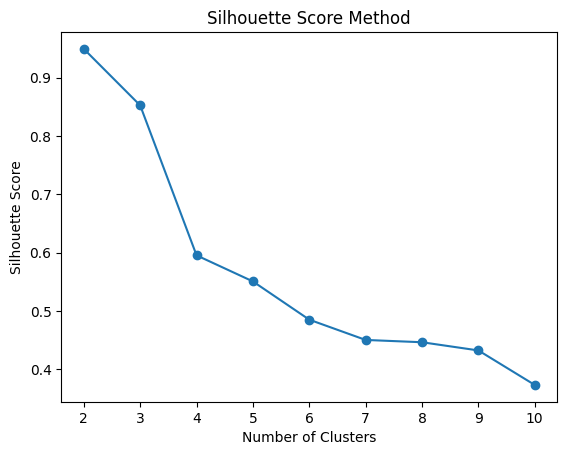

In [139]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd

X = pd.DataFrame.from_dict(code2features, orient='index').fillna(0)

# Specify a range of cluster numbers to try
cluster_range = range(2, 11)

silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)  # Set n_init explicitly to 10 in order to suppress the warning
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

# Plot the Silhouette Score for different numbers of clusters
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

In [140]:
#k-means clustering and setting the number of cluster based on the highest silhouette score

from sklearn.cluster import KMeans
import pandas as pd


X = pd.DataFrame.from_dict(code2features, orient='index').fillna(0)

# Number of clusters based on the silhouette score
n_clusters = 2

# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X)


X['cluster_label'] = cluster_labels


#Cluster 0: Detailed Interactors (students who provide detailed prompts and responses)
#Cluster 1: Concise Interactors (students who use shorter prompts and responses)
cluster_label_mapping = {0: "Detailed Interactors", 1: "Concise Interactors"}
X['cluster_label'] = X['cluster_label'].map(cluster_label_mapping)
X['cluster_label']

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0031c86e-81f4-4eef-9e0e-28037abf9883    Detailed Interactors
0225686d-b825-4cac-8691-3a3a5343df2b    Detailed Interactors
041f950b-c013-409a-a642-cffff60b9d4b    Detailed Interactors
04f91058-d0f8-4324-83b2-19c671f433dc    Detailed Interactors
089eb66d-4c3a-4f58-b98f-a3774a2efb34    Detailed Interactors
                                                ...         
f24219d6-07f0-4baf-80ac-18475dc5b66f    Detailed Interactors
f2f18684-4a16-4c05-a2d1-c0f96d1de869    Detailed Interactors
f852596d-fdca-45aa-9050-d4f76ce6a53c    Detailed Interactors
f8ec3336-fd48-4654-ad98-62ccfb96d096    Detailed Interactors
fb8de815-224c-4d06-9fd4-7156d1a9920d    Detailed Interactors
Name: cluster_label, Length: 123, dtype: object

In [141]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,#yes,#correct,#exactly,#certainly,#sure,#good,#well,#bad,#here,#how,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2.205748,212.206370
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.304163,113.633582
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.262324,17.187601
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.123346,107.092566
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,20.0,0.017986,18.850913


In [142]:
# reading the scores
scores = pd.read_csv("scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


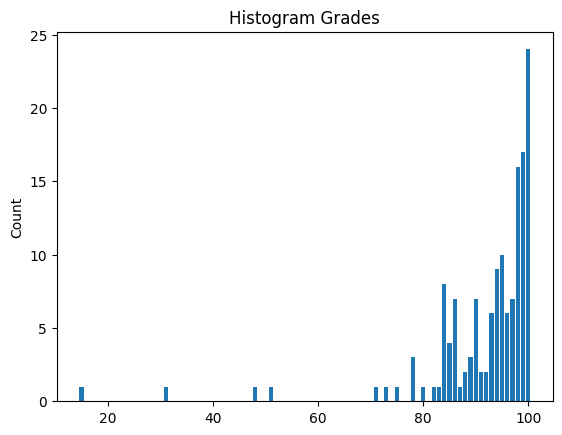

In [143]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [144]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#yes,#correct,#exactly,#certainly,#sure,#good,#well,#bad,#here,#how,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2.205748,212.206370
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.304163,113.633582
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.262324,17.187601
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.123346,107.092566
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,20.0,0.017986,18.850913


In [145]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#yes,#correct,#exactly,...,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,212.206370,0.953362,0.923971,0.902093,0.884738,0.947819,0.893758,0.838053,0.843031,0.849378
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,113.633582,0.956489,0.929728,0.955975,0.978713,0.937166,0.998894,0.978150,0.926051,0.970492
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,...,17.187601,0.946859,0.909167,0.929063,0.815073,0.939542,0.870206,0.886104,0.924163,0.815470
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,...,107.092566,0.944806,0.917503,0.863061,0.847306,0.892309,0.896931,0.914685,0.927192,0.965435
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,1.0,3.0,1.0,...,18.850913,0.968744,0.929187,0.953297,0.946568,0.953747,0.980292,0.977769,0.995987,0.959771


#### Merging scores with features

In [146]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#yes,#correct,#exactly,...,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.953362,0.923971,0.902093,0.884738,0.947819,0.893758,0.838053,0.843031,0.849378,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.956489,0.929728,0.955975,0.978713,0.937166,0.998894,0.978150,0.926051,0.970492,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,...,0.946859,0.909167,0.929063,0.815073,0.939542,0.870206,0.886104,0.924163,0.815470,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.944806,0.917503,0.863061,0.847306,0.892309,0.896931,0.914685,0.927192,0.965435,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,1.0,3.0,1.0,...,0.968744,0.929187,0.953297,0.946568,0.953747,0.980292,0.977769,0.995987,0.959771,100.0


In [147]:
##new
# Gerekli kütüphane import edilir
from textblob import TextBlob

# Duyarlılık analizi fonksiyonu
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Duyarlılık analizi ile yeni özellik hesaplanması
for code, convos in code2convos.items():
    sentiments = [calculate_sentiment(convo["text"]) for convo in convos if convo["role"] == "user"]
    avg_sentiment = sum(sentiments) / len(sentiments) if sentiments else 0
    code2features[code]["avg_sentiment"] = avg_sentiment

# Yeni özelliklerin DataFrame'e eklenmesi
features_df = pd.DataFrame.from_dict(code2features, orient='index')
features_df.reset_index(inplace=True)
features_df.rename(columns={'index': 'code'}, inplace=True)

# Ana DataFrame ile birleştirme
temp_df = pd.merge(temp_df, features_df[['code', 'avg_sentiment']], on='code', how='left')

# Sonraki adımlar: Özellik ölçeklendirme, model eğitimi, vb.


In [148]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 28) (122,)


#### Train/Test split

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


#### Fitting a model

#### Predicting and Analyzing

In [150]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np

# max_depth_arr = [i for i in range(1, max_depth + 1)]
# min_sample_splits = [i for i in range(2, 21)]

param_grid = {
    'max_depth': [5, 8, 12, 16],
    'min_samples_split': [2, 4, 10, 20]
}


regressor = RandomForestRegressor(n_estimators=200)
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')

grid_search.fit(X_train, y_train)
cols_to_include = ['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)
results.head(50)
print(results["param_max_depth"])

0      5
1      5
2      5
3      5
4      8
5      8
6      8
7      8
8     12
9     12
10    12
11    12
12    16
13    16
14    16
15    16
Name: param_max_depth, dtype: object


In [151]:
regressor = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth = results["param_max_depth"][0],
    min_samples_split = results["param_min_samples_split"][0]
)

regressor.fit(X_train, y_train)

# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Map predictions to the (0, 100) range
y_train_pred = np.clip(y_train_pred, 0, 100)
y_test_pred = np.clip(y_test_pred, 0, 100)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train, y_train_pred))
print("MSE TEST:", mean_squared_error(y_test, y_test_pred))

print("R2 Train:", r2_score(y_train, y_train_pred))
print("R2 TEST: ",r2_score(y_test, y_test_pred)*100)

# Cross-validation
cv_scores = cross_val_score(regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores = -cv_scores
print("Cross-Validation Scores:", cv_scores)

MSE Train: 3.1182987249004004
MSE TEST: 0.5515566000250214
R2 Train: 0.9809185399905908
R2 TEST:  99.50870382376701
Cross-Validation Scores: [ 14.9478   0.3077   0.2475 193.9654   0.2051]


In [152]:
data_path = "data2/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 188/188 [01:00<00:00,  3.09it/s]


In [153]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [154]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [164]:
import gensim.downloader
from gensim.models import Word2Vec

sentences = [prompt.split() for prompt in prompts]

vector_size = 500
window = 5
min_count = 5

w2v_model = Word2Vec(
    sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=4)

In [165]:
import gensim.downloader as api
import numpy as np

def document_vector(word2vec_model, doc):
    words = doc.split()
    word_vectors = []

    for word in words:
        if word in word2vec_model.wv:
            word_vectors.append(word2vec_model.wv[word])

    if not word_vectors:
        return np.zeros(word2vec_model.vector_size)

    document_vector = np.mean(word_vectors, axis=0)
    return document_vector

code2_word2vec_prompts = dict()

for code, user_prompts in code2prompts.items():
  if len(user_prompts) == 0:
      # some files have issues
      print(code+".html")
      continue

  word2_vec = pd.DataFrame([document_vector(w2v_model, doc) for doc in user_prompts],
                               columns={i: f"Q_{i}" for i in range(w2v_model.vector_size)})
  code2_word2vec_prompts[code] = word2_vec

question_word2vec = pd.DataFrame([document_vector(w2v_model, doc) for doc in questions], columns={i: f"Q_{i}" for i in range(w2v_model.vector_size)})

In [166]:
from sklearn.preprocessing import normalize
code2cosine = dict()
for code, user_prompts_word2vec in code2_word2vec_prompts.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(question_word2vec, user_prompts_word2vec))

code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()

question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,00941713-c3a2-4d27-81dc-cd447ace4a47,0.836108,0.726151,0.731582,0.651917,0.931495,0.997040,0.873922,0.809640,0.657309
1,00aea02f-a95a-4c04-8be3-777461732cdf,0.888696,0.826345,0.788857,0.824386,0.887971,0.868604,0.938265,0.882714,0.937396
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,0.869043,0.842670,0.949125,0.976642,0.935023,0.976474,0.938312,0.861498,0.958561
3,05029661-f8d8-441b-9cab-3c79f28a8b26,0.862851,0.942238,0.948286,0.958436,0.919565,0.997645,0.934643,0.994822,0.971743
4,059a146e-a37c-498f-8c0b-5a78204249cb,0.844571,0.800338,0.942854,0.971909,0.919930,0.806903,0.903056,0.972314,0.952467
...,...,...,...,...,...,...,...,...,...,...
183,fab774ac-38c8-4d86-910c-7ad0fa8470c5,0.888545,0.983265,0.933963,0.974681,0.941086,0.990884,0.998530,0.921831,0.925014
184,fac3042d-d72d-43a7-9170-a424e3061fac,0.875693,0.788218,0.949125,0.984751,0.994431,0.997648,0.970598,0.953037,0.934936
185,fbf473eb-ea6f-4a4a-b2d8-405bc09f9850,0.874272,0.843620,0.756985,0.668702,0.889179,0.936943,0.972941,0.889221,0.857959
186,fccd270d-63f8-42b6-b73e-13f6d3e5f612,0.859507,0.916557,0.933974,0.971909,0.918224,0.997510,0.990692,0.926575,0.930414


In [167]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy", "yes", "correct", "exactly", "certainly", "sure", "good", "well", "bad", "here", "how"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

In [168]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,#yes,#correct,#exactly,#certainly,#sure,#good,#well,#bad,#here,#how,prompt_avg_chars,response_avg_chars
00941713-c3a2-4d27-81dc-cd447ace4a47,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12.105281,26.788701
00aea02f-a95a-4c04-8be3-777461732cdf,39.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.098639,68.348483
04fdb619-d902-4e98-a5e9-a8198bfe047c,33.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.956996,37.435518
05029661-f8d8-441b-9cab-3c79f28a8b26,63.0,0.0,1.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,5.0,9.0,0.008067,17.912278
059a146e-a37c-498f-8c0b-5a78204249cb,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.367686,121.715104


In [169]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#yes,#correct,#exactly,#certainly,#sure,#good,#well,#bad,#here,#how,prompt_avg_chars,response_avg_chars
0,00941713-c3a2-4d27-81dc-cd447ace4a47,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12.105281,26.788701
1,00aea02f-a95a-4c04-8be3-777461732cdf,39.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.098639,68.348483
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,33.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.956996,37.435518
3,05029661-f8d8-441b-9cab-3c79f28a8b26,63.0,0.0,1.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,5.0,9.0,0.008067,17.912278
4,059a146e-a37c-498f-8c0b-5a78204249cb,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.367686,121.715104


In [170]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

df.dropna(inplace=True)
df.drop_duplicates("code",inplace=True, keep="first")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#yes,#correct,#exactly,...,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,00941713-c3a2-4d27-81dc-cd447ace4a47,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26.788701,0.836108,0.726151,0.731582,0.651917,0.931495,0.997040,0.873922,0.809640,0.657309
1,00aea02f-a95a-4c04-8be3-777461732cdf,39.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,...,68.348483,0.888696,0.826345,0.788857,0.824386,0.887971,0.868604,0.938265,0.882714,0.937396
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,33.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,...,37.435518,0.869043,0.842670,0.949125,0.976642,0.935023,0.976474,0.938312,0.861498,0.958561
3,05029661-f8d8-441b-9cab-3c79f28a8b26,63.0,0.0,1.0,0.0,0.0,8.0,0.0,0.0,0.0,...,17.912278,0.862851,0.942238,0.948286,0.958436,0.919565,0.997645,0.934643,0.994822,0.971743
4,059a146e-a37c-498f-8c0b-5a78204249cb,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,...,121.715104,0.844571,0.800338,0.942854,0.971909,0.919930,0.806903,0.903056,0.972314,0.952467


In [171]:
##new
# Gerekli kütüphane import edilir
from textblob import TextBlob

# Duyarlılık analizi fonksiyonu
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Duyarlılık analizi ile yeni özellik hesaplanması
for code, convos in code2convos.items():
    sentiments = [calculate_sentiment(convo["text"]) for convo in convos if convo["role"] == "user"]
    avg_sentiment = sum(sentiments) / len(sentiments) if sentiments else 0
    code2features[code]["avg_sentiment"] = avg_sentiment

# Yeni özelliklerin DataFrame'e eklenmesi
features_df = pd.DataFrame.from_dict(code2features, orient='index')
features_df.reset_index(inplace=True)
features_df.rename(columns={'index': 'code'}, inplace=True)

# Ana DataFrame ile birleştirme
temp_df = pd.merge(df, features_df[['code', 'avg_sentiment']], on='code', how='left')

# Sonraki adımlar: Özellik ölçeklendirme, model eğitimi, vb.
temp_df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#yes,#correct,#exactly,...,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,avg_sentiment
0,00941713-c3a2-4d27-81dc-cd447ace4a47,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.836108,0.726151,0.731582,0.651917,0.931495,0.997040,0.873922,0.809640,0.657309,0.149959
1,00aea02f-a95a-4c04-8be3-777461732cdf,39.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.888696,0.826345,0.788857,0.824386,0.887971,0.868604,0.938265,0.882714,0.937396,0.014744
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,33.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.869043,0.842670,0.949125,0.976642,0.935023,0.976474,0.938312,0.861498,0.958561,0.060799
3,05029661-f8d8-441b-9cab-3c79f28a8b26,63.0,0.0,1.0,0.0,0.0,8.0,0.0,0.0,0.0,...,0.862851,0.942238,0.948286,0.958436,0.919565,0.997645,0.934643,0.994822,0.971743,0.138591
4,059a146e-a37c-498f-8c0b-5a78204249cb,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.844571,0.800338,0.942854,0.971909,0.919930,0.806903,0.903056,0.972314,0.952467,0.098712


In [172]:
features_for_prediction = temp_df.drop(['code'], axis=1)
features_array = features_for_prediction.to_numpy()
predicted_scores = regressor.predict(features_array)
print(predicted_scores)

[38.77   41.255  37.065  39.3557 39.495  36.675  37.365  40.4057 38.6057
 39.8657 37.955  33.6957 39.0557 35.8957 38.5957 38.0157 38.6    35.7757
 39.6657 43.33   37.5757 41.2357 35.4157 37.715  33.435  38.025  34.5657
 36.935  38.0957 38.215  35.7357 35.3657 39.5557 41.58   41.76   38.4957
 37.6357 35.465  36.8957 38.88   38.7557 38.1257 38.32   35.4457 39.205
 38.015  36.4557 43.09   36.055  35.0957 37.3457 33.9157 38.6    36.015
 39.455  35.5657 36.7757 36.2257 37.9857 37.5757 40.245  39.6657 37.1757
 40.3    40.215  38.1157 40.34   36.7757 34.005  35.8457 36.235  36.1657
 37.7857 40.89   39.75   37.905  38.345  35.325  37.6457 36.4657 38.0857
 39.24   42.73   39.415  38.145  39.4757 35.3257 40.53   35.785  41.025
 39.12   37.5857 38.9557 37.015  37.9657 40.1157 41.865  37.9557 36.5057
 37.5357 41.5057 33.9057 41.255  38.415  39.43   36.3157 35.0857 41.39
 38.075  37.2857 37.2057 39.285  39.365  40.705  38.935  37.7957 37.6857
 35.915  40.43   35.1157 37.4857 40.315  43.13   37.9257